
# 문제정의
이 대회는 많은 사람을 죽음으로 몰고 간 `Titanic 호 침몰 사건`을 주제로 다룬다.


생존에 영향을 미친 여러 요인이 있겠지만, 대회에서 주어진 Train 승객들의 정보만으로 Test 승객들의 생존 여부를 예측해보려고 한다.


생존과 연루되어 있다고 생각되는 몇 가지의 요소들에 대해 분석하여 어떤 조건을 갖춘 그룹들이 생존할 확률이 더 높았는지에 대해 알아보려고 한다.




# 데이터 수집

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
from collections import Counter
import matplotlib as mpl
import random
from copy import deepcopy
from collections import defaultdict
from pandas.plotting import parallel_coordinates
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
warnings.filterwarnings(action = 'ignore')
plt.rcParams['font.family'] = 'KBIZmjo M'
%matplotlib inline

In [64]:
train = pd.read_csv('Desktop/데이터분석/titanic/train.csv')
test = pd.read_csv('Desktop/데이터분석/titanic/test.csv')
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [66]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

----------------------------------------------------
총 891명의 탑승자가 있다.(학습대상) 



하지만 Age, Cabin, Embarked는 몇몇 탑승자들의 정보가 누락되어있다.

- Age : 177명 누락(약 20%)
- Cabin : 687명 누락(약 77%)
- Embarked : 2명 누락(약 0.2%)


In [67]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [68]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

---------------------------------------------
test탑승자의 정보도 일부 누락되어있다. --> Age, Fare, Cabin  

In [69]:
train.Survived.value_counts() 

0    549
1    342
Name: Survived, dtype: int64

In [70]:
Dead_num = 549
Survived_num = 342

-----------------------------------------
전체 train탑승객 중 사망자는 549명, 생존자는 342명이다.

<br><br>
# 데이터 전처리


- ## 중복데이터 삭제

In [71]:
train = train.drop_duplicates()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [72]:
test = test.drop_duplicates()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


- ## 불필요한 컬럼 삭제

In [73]:
ticket_dict = defaultdict(list)
for t_num , p_id in zip(train.Ticket, train.PassengerId):
    ticket_dict[t_num].append(p_id)

In [74]:
cnt = 0 #동승자 수+1(자기자신)과 Ticket번호가 동일한 승객수와 맞지 않는 경우 count
sp_dict = defaultdict(list)#key : sibsp+parch , value : passengerid
for k,v in ticket_dict.items():
    for s1, s2, p_id in zip(train.loc[train['Ticket']==k, 'SibSp'],train.loc[train['Ticket']==k, 'Parch'], train.loc[train['Ticket']==k,'PassengerId']):
        sp_dict[s1+s2].append(p_id) 
        if s1+s2+1 != len(v):
            cnt += 1
print(cnt)

288


--------------------------------------------------------------------
동승자는 Ticket번호가 모두 같을 것이기에 

동일 Ticket번호 개수 = SibSp + Parch + 1(자기자신) 일것이라 생각했다.

그런데 둘의 값이 다른 승객이 288명으로 꽤 많다.

그래서 일단 모두 활용해봐야겠다.

In [75]:
#SibSp + Parch 
train['Family']  = [i+j for i,j in zip(train.SibSp, train.Parch)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Family         891 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 97.5+ KB


In [76]:
#SibSp + Parch 
test['Family']  = [i+j for i,j in zip(test.SibSp, test.Parch)]
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Family         418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 42.5+ KB


In [77]:
#활용하지 않을 컬럼 drop
train = train.drop(['Name'], axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Family         891 non-null int64
dtypes: float64(2), int64(6), object(4)
memory usage: 90.5+ KB


In [78]:
test = test.drop(['Name'], axis = 1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Family         418 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 39.2+ KB


----------------------------------
생성)
Family : SibSp + Parch 값


삭제)
Name : 칭호를 분리해서 분석해볼 수 있지만 칭호는 Pclass, Fare 등 대체 할 수 있는 컬럼이 많기에 drop

- ## 데이터 타입 바꾸기

In [79]:
#알파벳 별 숫자 부여(대문자)
Cabin_dict = defaultdict(int)
for i,j in enumerate(range(65,91)):
    Cabin_dict[chr(j)] = i+1

In [80]:
#맨앞 알파벳만 따서 알파벳별 숫자 부여 (즉, string -> int)
for c, idx in zip(train.loc[train.Cabin.notnull()].Cabin, train.loc[train.Cabin.notnull()].index):
    train.set_value(idx,'Cabin', Cabin_dict[c[0].upper()])
train[train['Cabin'].notnull()].head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,3,C,1
3,4,1,1,female,35.0,1,0,113803,53.1000,3,S,1
6,7,0,1,male,54.0,0,0,17463,51.8625,5,S,0
10,11,1,3,female,4.0,1,1,PP 9549,16.7000,7,S,2
11,12,1,1,female,58.0,0,0,113783,26.5500,3,S,0


In [81]:
#test도 적용
for c, idx in zip(test.loc[test.Cabin.notnull()].Cabin, test.loc[test.Cabin.notnull()].index):
    test.set_value(idx,'Cabin', Cabin_dict[c[0].upper()])
test[test['Cabin'].notnull()].head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
12,904,1,female,23.0,1,0,21228,82.2667,2,S,1
14,906,1,female,47.0,1,0,W.E.P. 5734,61.1750,5,S,1
24,916,1,female,48.0,1,3,PC 17608,262.3750,2,C,4
26,918,1,female,22.0,0,1,113509,61.9792,2,C,1
28,920,1,male,41.0,0,0,113054,30.5000,1,S,0


In [82]:
for i in ['Sex', 'Embarked','Cabin']:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
#string -> int
train['Sex'].cat.categories = [1,2]
test['Sex'].cat.categories = [1,2]
train['Embarked'].cat.categories = [1,2,3]
test['Embarked'].cat.categories = [1,2,3]

In [83]:
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,2,22.0,1,0,A/5 21171,7.2500,NaN,3,1
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,3,1,1
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,3,0
3,4,1,1,1,35.0,1,0,113803,53.1000,3,3,1
4,5,0,3,2,35.0,0,0,373450,8.0500,NaN,3,0


---------------
이제 Ticket을 제외한 나머지 컬럼의 데이터 타입은 int 또는 float이다.

- ## 결측치 처리

train 데이터)
    - Age : 다른 데이터로 추정하여 대체 or 해당 행 삭제
    - Cabin : 그냥 두거나 다른 데이터로 추정하여 대체(분석 후 결정)
    - Embarked : 해당 행 삭제
    
test 데이터)
    - Age : 다른 데이터로 추정하여 대체
    - Fare : 다른 데이터로 추정하여 대체
    - Cabin : 그냥 두거나 다른 데이터로 추정하여 대체(분석 후 결정)
    

In [84]:
#Embarked결측치 삭제
train = train.drop(train.loc[train.Embarked.isnull()].index) 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null category
Embarked       889 non-null category
Family         889 non-null int64
dtypes: category(3), float64(2), int64(6), object(1)
memory usage: 72.6+ KB


In [85]:
#Age 결측치 삭제
train_del_age = train.drop(train.loc[train.Age.isnull()].index)

In [86]:
from sklearn.ensemble import RandomForestRegressor
def predict (dat, target, feature):#전체 데이터, 대상 컬럼, 예측에 활용될 컬럼list
    #target값이 Null인것과 Null이 아닌 것 구분
    Not_Null = dat.loc[dat[target].notnull()]
    Is_Null = dat.loc[dat[target].isnull()]
    
    Is_Null[target] = Is_Null[target].astype('str')
    
    #랜덤포레스트 회귀를 활용한다.
    rfModel = RandomForestRegressor()
    
    #feature에 있는 피처의 값을 바탕으로 학습시킨다.
    rfModel.fit(Not_Null[feature], Not_Null[target])
    
    #학습한 값을 바탕으로 예측한다.
    predicted_val = rfModel.predict(X = Is_Null[feature])
    
    #예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    Is_Null_cpy = Is_Null
    Not_Null_cpy= Not_Null
    
    #결측치가 있는 데이터 프레임에 예측값을 넣어줌
    Is_Null_cpy[target] = predicted_val
    
    #결측치가 없는 데이터 프레임에 예측한 값이 있는 데이터프레임을 합친다.
    dat = Not_Null_cpy.append(Is_Null_cpy)
    dat[target] = dat[target].astype('float')
    
    dat.reset_index(inplace = True)
    dat.drop('index', inplace = True, axis =1)
    return dat

In [147]:
from sklearn.ensemble import RandomForestClassifier
def predict_csf (dat, target, feature):#전체 데이터, 대상 컬럼, 예측에 활용될 컬럼list
    #target값이 Null인것과 Null이 아닌 것 구분
    Not_Null = dat.loc[dat[target].notnull()]
    Is_Null = dat.loc[dat[target].isnull()]
    
    Is_Null[target] = Is_Null[target].astype('str')
    
    #랜덤포레스트분류를 활용한다.
    rfModel = RandomForestClassifier()
    
    #feature에 있는 피처의 값을 바탕으로 학습시킨다.
    rfModel.fit(Not_Null[feature], Not_Null[target])
    
    #학습한 값을 바탕으로 예측한다.
    predicted_val = rfModel.predict(X = Is_Null[feature])
    
    #예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    Is_Null_cpy = Is_Null
    Not_Null_cpy= Not_Null
    
    #결측치가 있는 데이터 프레임에 예측값을 넣어줌
    Is_Null_cpy[target] = predicted_val
    
    #결측치가 없는 데이터 프레임에 예측한 값이 있는 데이터프레임을 합친다.
    dat = Not_Null_cpy.append(Is_Null_cpy)
    dat[target] = dat[target].astype('int')
    
    dat.reset_index(inplace = True)
    dat.drop('index', inplace = True, axis =1)
    return dat

In [88]:
#나이 예측
train_age = predict(train,'Age',['Pclass', 'Fare','Sex','Embarked'])
train_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null category
Embarked       889 non-null category
Family         889 non-null int64
dtypes: category(3), float64(2), int64(6), object(1)
memory usage: 65.8+ KB


In [89]:
#나이 예측 후
train_age.Age.describe()

count    889.000000
mean      29.750263
std       13.648168
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [90]:
#나이 예측 전
train.Age.describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [91]:
#test도 예측
#먼저 Fare부터
test = predict(test, 'Fare', ['Pclass','Sex'])
#이후 Age 예측
test_age = predict(test, 'Age', ['Pclass', 'Fare','Sex','Embarked'])
test_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null category
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null category
Embarked       418 non-null category
Family         418 non-null int64
dtypes: category(3), float64(2), int64(5), object(1)
memory usage: 28.0+ KB


In [92]:
#예측 후
test_age.Age.describe()

count    418.000000
mean      29.480401
std       13.128059
min        0.170000
25%       22.000000
50%       26.000000
75%       36.000000
max       76.000000
Name: Age, dtype: float64

In [93]:
#예측 전
test.Age.describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

In [149]:
#Cabin 예측(컬럼 2개로)
test_cabin_2 = predict_csf(test_age, 'Cabin',['Pclass', 'Fare'])
train_cabin_2 = predict_csf(train_age, 'Cabin',['Pclass', 'Fare'])

In [156]:
#Cabin 예측(컬럼 3개로)
test_cabin_3 = predict_csf(test_age, 'Cabin', ['Pclass', 'Fare', 'Age'])
train_cabin_3 = predict_csf(train_age, 'Cabin', ['Pclass','Fare','Age'])

In [96]:
#Dead_num , Survived_num 갱신
Dead_num = len(train[train.Survived==0])
Survived_num = len(train[train.Survived==1])

In [97]:
train_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null category
Embarked       889 non-null category
Family         889 non-null int64
dtypes: category(3), float64(2), int64(6), object(1)
memory usage: 65.8+ KB


<br><br>
# 데이터 마이닝


<br><br><br>
- ## 나이가 아주 어리거나 많고 여자일수록 생존 확률이 높을 것이다.

In [98]:
#연령대 분류 함수
def AgeClassify(k):
    if k<10.0: 
        return 0
    elif k<20.0:#10대
        return 10
    elif k<30.0:#20대
        return 20
    elif k<40.0:#30대
        return 30
    elif k<50.0:#40대
        return 40
    elif k<60.0:#50대
        return 50
    elif k<70.0:#60대
        return 60
    elif k<80.0:#70대
        return 70
    elif k>=80.0:
        return 80

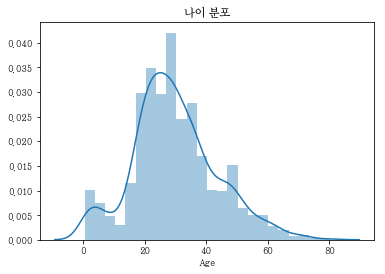

In [99]:
plt.title('나이 분포')
sns.distplot(train_age.Age)
plt.show()

In [100]:
train_age.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,29.750263,0.524184,0.382452,32.096681,0.906637
std,256.998173,0.486260,0.834700,13.648168,1.103705,0.806761,49.697504,1.614703
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.000000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


-------------------------
20대~30대 후반까지의 승객이 가장 많고, 최고 고령자는 80세이다.

다음은 연령대별 생존확률에 대해 알아보겠다.

In [101]:
age_dict = defaultdict(int) #key : 연령대, value : 해당하는 사람 수 
for i in train_age.Age:
    age_dict[AgeClassify(i)] += 1
age_dict

defaultdict(int,
            {20: 306,
             30: 216,
             50: 55,
             0: 64,
             10: 116,
             40: 107,
             60: 18,
             70: 6,
             80: 1})

In [102]:
#key: 연령 ,value: 생존자 수
age_surv_dict = defaultdict(int)
for i,j in zip(train_age.Age, train_age.Survived):
    age_surv_dict[AgeClassify(i)] += j

for k,v in age_dict.items():
    age_surv_dict[k] /= v #해당 연령 생존자 수/ 해당 연령 수

age_surv_dict

defaultdict(int,
            {20: 0.33986928104575165,
             30: 0.375,
             50: 0.41818181818181815,
             0: 0.625,
             10: 0.4224137931034483,
             40: 0.34579439252336447,
             60: 0.2777777777777778,
             70: 0.0,
             80: 1.0})

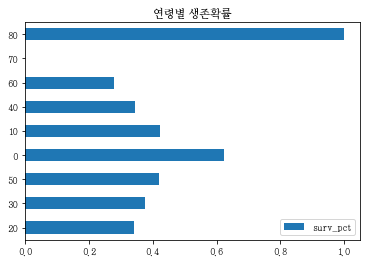

In [103]:
pd.DataFrame.from_dict(age_surv_dict, orient = 'index', columns = ['surv_pct']).plot.barh()
plt.title('연령별 생존확률')
plt.show()

-----------
70대의 생존확률은 0%이고, 80대는 100%라고 나오지만, 70, 80대의 승객은 거의 없기 때문에 신뢰할 수 없다.


가장 생존 확률이 높은 것은 10세 미만인 승객인 것을 확인할 수 있다.

In [104]:
#여자 생존 확률
fe_num = len(train.loc[train.Sex == 1].PassengerId)
surv_fe_pct = len(train.loc[(train.Survived == 1) & (train.Sex == 1)].PassengerId)/fe_num
surv_fe_pct

0.7403846153846154

In [105]:
#남자 생존 확률
m_num= len(train.loc[train.Sex == 2].PassengerId)
surv_m_pct = len(train.loc[(train.Survived == 1) &(train.Sex == 2)].PassengerId)/m_num
surv_m_pct

0.18890814558058924

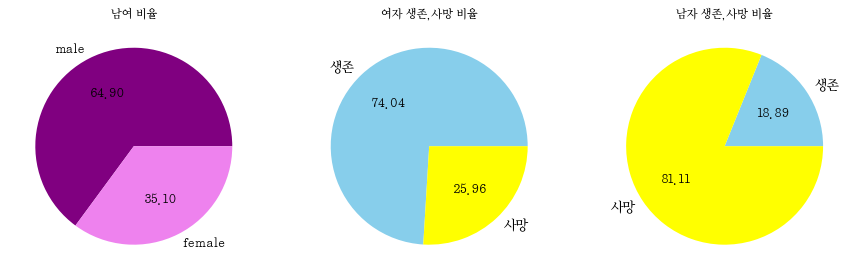

In [106]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
ax[0].set_title('남여 비율')
ax[0].pie(train.Sex.value_counts(), labels = ['male','female'],colors = ['purple','violet'],autopct = '%.2f',textprops={'fontsize': 14} )


ax[1].set_title('여자 생존,사망 비율')
ax[1].pie([surv_fe_pct, 1-surv_fe_pct], labels = ['생존','사망'],colors = ['skyblue','yellow'],autopct = '%.2f',textprops={'fontsize': 14} )


ax[2].set_title('남자 생존,사망 비율')
ax[2].pie([surv_m_pct, 1-surv_m_pct], labels = ['생존','사망'],colors = ['skyblue','yellow'],autopct = '%.2f',textprops={'fontsize': 14} )

plt.show()


----------------
여자인 승객 중 생존자는 74.04%

남자인 승객 중 생존자는 18.89%

55.15%p 차이가 난다.

성별이 1(여자)이면 생존했을 확률이 높다는 것을 뒷받침해주는 결과이다.

In [107]:
Survived_dict = {1:[]}
for s_id in train.loc[train.Survived == 1].PassengerId:
    Survived_dict[1].append(s_id)
print(len(Survived_dict[1]))

340


In [108]:
#여자이고 나이가 10대 이하인 승객
w_y_num = 0
under_10_num = 0
for i,age in zip(train_age.loc[train_age.Sex == 1].PassengerId, train_age.loc[train_age.Sex == 1].Age):
    if AgeClassify(age) <= 10:
        under_10_num +=1
        if i in Survived_dict[1] :
            w_y_num += 1

w_y_surv_pct = w_y_num/under_10_num
print(w_y_surv_pct)
print(under_10_num)

0.7159090909090909
88


In [109]:
#남자이고 나이가 10대 이하인 승객
m_y_num = 0
under_10_num = 0
for i,age in zip(train_age.loc[train_age.Sex == 2].PassengerId, train_age.loc[train_age.Sex == 2].Age):
    if AgeClassify(age) <= 10:
        under_10_num +=1
        if i in Survived_dict[1] :
            m_y_num += 1

m_y_surv_pct = m_y_num/under_10_num
print(m_y_surv_pct)
print(under_10_num)

0.2826086956521739
92


In [110]:
0.7209302325581395 - 0.2826086956521739

0.4383215369059656

In [111]:
#여자이고 나이가 50이상인 승객
w_o_num = 0
over_50_num = 0
for i,age in zip(train_age.loc[train_age.Sex == 1].PassengerId, train_age.loc[train_age.Sex == 1].Age):
    if AgeClassify(age) >= 50:
        over_50_num +=1
        if i in Survived_dict[1] :
            w_o_num += 1

w_o_surv_pct = w_o_num/over_50_num
print(w_o_surv_pct)
print(over_50_num)

0.9090909090909091
22


In [112]:
#남자이고 나이가 50이상인 승객
m_o_num = 0
over_50_num = 0
for i,age in zip(train_age.loc[train_age.Sex == 2].PassengerId, train_age.loc[train_age.Sex == 2].Age):
    if AgeClassify(age) >= 50:
        over_50_num +=1
        if i in Survived_dict[1] :
            m_o_num += 1

m_o_surv_pct = m_o_num/over_50_num
print(m_o_surv_pct)
print(over_50_num)

0.15517241379310345
58


In [113]:
0.9047619047619048 - 0.14545454545454545

0.7593073593073594

-------------------------------
- 10대 이하(즉 0~19세) 
    
    
    여자 : 72.09%
    남자 : 28.26%
    차이 : 43.83%p



- 50대 이상(즉, 50~80세)
    
    
    여자 : 90.48%
    남자 : 14.55%
    차이 : 75.93%p
    
    
    
- 여자


    10대 이하 : 72.09%
    50대 이상 : 90.48%
    차이 : 18.39%p



- 남자


    10대 이하 : 28.26%
    50대 이상 : 14.55%
    차이 : 13.71%p
 
<br>


위 결과를

나이도 무시할 순 없지만, 

나이보다는 <strong>성별이 생존여부에 더 큰 영향</strong>을 주는 것으로 해석했다.

<br><br><br>
- ## 동승자가 없는(혼자 온) 승객은 사망 확률이 높을 것이다.

In [114]:
#Ticket
t_together_survived = 0 #동일 Ticket을 가진 승객이 있고, 생존한 승객 count
t_alone_survived = 0 #동일 Ticket을 가진 승객이 없고(즉, 혼자), 생존한 승객 count
t_alone_dead  = 0 #혼자이고 사망한 승객count
t_together_cnt =0 #len(v) >1인 승객 count
t_alone_cnt = 0 #len(v) <= 1인 승객 count
for k,v in ticket_dict.items():
    if len(v) <=1:
        for vv in v:
            t_alone_cnt += 1
            try:
                if int(train[train['PassengerId']==vv].Survived) == 1:
                    t_alone_survived += 1
                if int(train[train['PassengerId']==vv].Survived) == 0:
                    t_alone_dead += 1
            except:
                continue
    else:
        for vv in v: 
            t_together_cnt += 1 
            try:
                if int(train[train['PassengerId']==vv].Survived) == 1:
                    t_together_survived += 1
            except:
                continue

a_surv_pct = t_alone_survived/Survived_num
surv_a_pct = t_alone_survived/t_alone_cnt
a_dead_pct = t_alone_dead/Dead_num
dead_a_pct = t_alone_dead/t_alone_cnt
t_surv_pct = t_together_survived / Survived_num 
surv_t_pct = t_together_survived /t_together_cnt
print('P(a|surv) = ' , a_surv_pct)
print('P(surv|a) = ', surv_a_pct)
print('P(a|dead) = ',a_dead_pct)
print('P(dead|a) = ', dead_a_pct)
print('P(t|surv) = ',t_surv_pct)
print('P(surv|t) = ',surv_t_pct)

P(a|surv) =  0.47941176470588237
P(surv|a) =  0.2979890310786106
P(a|dead) =  0.6994535519125683
P(dead|a) =  0.7020109689213894
P(t|surv) =  0.5205882352941177
P(surv|t) =  0.5145348837209303


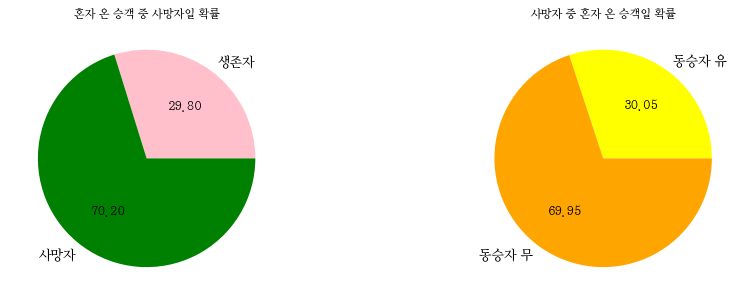

In [115]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].set_title('혼자 온 승객 중 사망자일 확률')
ax[0].pie([1-dead_a_pct,dead_a_pct],labels=['생존자','사망자'],colors = ['pink','green'],autopct = '%.2f',textprops={'fontsize': 14})

ax[1].set_title('사망자 중 혼자 온 승객일 확률')
ax[1].pie([1-a_dead_pct,a_dead_pct],labels = ['동승자 유', '동승자 무'], colors = ['yellow', 'orange'], autopct = '%.2f' ,textprops={'fontsize': 14})
plt.show()

------------------------------
- 생존자 중 혼자 온 승객은 47.94%

- 혼자 온 승객 중 생존자일 확률은 29.80%

- <strong>사망한 승객 중 혼자 온 승객일 확률은 69.95%

- 혼자 온 승객 중 사망자일 확률은 70.20%</strong>

- 생존자 중 동승자가 있는 승객일 확률은 52.34%

- 동승자가 있는 승객 중 생존자일 확률은 52.03% 




<br><br>


위 결과를

'동승자가 있는 승객이 생존할 확률이 높다'고 할순없지만,


<strong>'동승자가 없는(혼자 온) 승객은 사망할 확률이 높다'</strong>고 해석했다.


<br><br><br>


- ## Pclass가 높고 Fare가 높은 승객은 생존 확률이 높을 것이다. 

In [116]:
#key: pclass , value : 해당하는 승객 PassengerId
pclass_dict = defaultdict(list)
for pc, p_id in zip(train.Pclass, train.PassengerId):
    pclass_dict[pc].append(p_id)

In [117]:
#key : pclass, value : 해당 pclass의 생존자 PassengerId
pclass_surv_dict = defaultdict(list)
for k,v in pclass_dict.items():
    for vv in v:
        if int(train.loc[train.PassengerId == vv].Survived) == 1:
            pclass_surv_dict[k].append(vv)

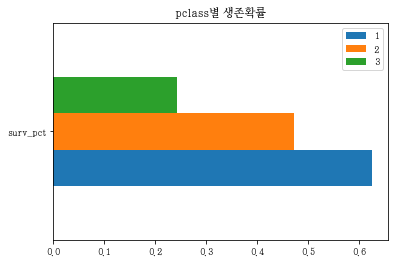

In [118]:
pclass_surv_df = pd.DataFrame([len(pclass_surv_dict[i])/len(pclass_dict[i]) for i in range(1,4)], index = [1,2,3], columns = ['surv_pct'])
pclass_surv_df.transpose().plot.barh()
plt.title('pclass별 생존확률')
plt.show()

In [119]:
pclass_surv_df

,surv_pct
1,0.626168
2,0.472826
3,0.242363


-----------------------
pclass가 높을수록(1에 가까울수록) 생존 확률이 높다.

In [120]:
train.Fare.describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [121]:
surv_fare_dict = {0:[], 1:[]}
for s,f in zip(train.Survived , train.Fare):
    surv_fare_dict[s].append(f)

In [122]:
c_num = 0
for i in Counter(surv_fare_dict[0]).most_common(10):
    c_num += i[0]
print(sorted(Counter(surv_fare_dict[0]).most_common(10)))
print('사망자의 Fare 최빈값 10개 평균:',c_num/10)

[(0.0, 14), (7.25, 12), (7.75, 22), (7.775, 13), (7.8958, 37), (8.05, 38), (8.6625, 12), (10.5, 15), (13.0, 26), (26.0, 16)]
사망자의 Fare 최빈값 10개 평균: 9.68833


In [123]:

c_num =0
for i in Counter(surv_fare_dict[1]).most_common(10):
    c_num += i[0]
print(sorted(Counter(surv_fare_dict[1]).most_common(10)))
print('생존자의 Fare 최빈값 10개 평균:',c_num/10)

[(7.75, 12), (7.8792, 4), (7.925, 8), (8.05, 5), (10.5, 9), (13.0, 16), (26.0, 15), (26.55, 8), (30.0, 5), (56.4958, 5)]
생존자의 Fare 최빈값 10개 평균: 19.415


In [124]:
#key : over은 Fare가 mean 초과, under은 Fare가 mean 이하 , value : key에 해당하는 승객 PassnerId 
mean_dict = {'over':[], 'under':[]} 
f_m = train.Fare.mean()
for f, p_id in zip(train.Fare,train.PassengerId):
    if f > f_m :
        mean_dict['over'].append(p_id)
    else:
        mean_dict['under'].append(p_id)


In [125]:
p1_mo_num = 0 #pclass가 1이고 Fare가 mean 초과인 승객
p1_mo_surv_num = 0 #pclass가 1이고 Fare가 mean초과인 승객 중 생존자
for i in mean_dict['over']:
    if i in pclass_dict[1]:
        p1_mo_num += 1
        if i in pclass_surv_dict[1]:
            p1_mo_surv_num += 1
    

In [126]:
p1_mo_num/len(mean_dict['over'])

0.7511961722488039

In [127]:
p1_mo_surv_num /len(mean_dict['over'])

0.5119617224880383

------------------------

- 사망자의 Fare 최빈값 10개 평균: 9.68833
- 생존자의 Fare 최빈값 10개 평균: 19.415
- Fare가 mean 초과하는 승객 중 Pclass가 1인 승객은 75.12%
- Fare가 mean 초과하고 Pclass가 1인 승객 중 생존한 승객은 51.2%

<br><br>
위 결과를

<strong>'Pclass가 높을 수록, Fare가 높을 수록 생존 확률이 높다'</strong>고 해석했다.

- ## Cabin과 Embarked에 따라 생존 확률 차이가 클 것이다.

In [128]:
#key : cabin, value : key에 해당하는 전체 승객 id
cabin_dict = defaultdict(list)
#key : cabin , value: key에 해당하는 생존 승객 id
surv_cabin_dict = defaultdict(list)
#key : cabin , value: key에 해당하는 승객들의 생존확률
surv_cabin_pct = defaultdict(int)
for i,j in zip(train.loc[train.Cabin.notnull()].Cabin, train.loc[train.Cabin.notnull()].PassengerId) :
    cabin_dict[i].append(j)

for k,v in cabin_dict.items():
    for vv in v:
        if int(train.loc[train.PassengerId == vv].Survived) == 1:
            surv_cabin_dict[k].append(vv)
for pct, k in zip(list(i/j for i,j in zip([len(h) for h in surv_cabin_dict.values()],[len(g) for g in cabin_dict.values()])), surv_cabin_dict.keys()):
    surv_cabin_pct[k] = pct
surv_cabin_pct

defaultdict(int,
            {3: 0.5932203389830508,
             5: 0.75,
             7: 0.5,
             4: 0.7575757575757576,
             1: 0.4666666666666667,
             2: 0.7333333333333333,
             6: 0.6153846153846154})

In [129]:
surv_cabin_df = pd.DataFrame.from_dict(surv_cabin_pct, orient= 'index', columns = ['생존 확률'])
surv_cabin_df

,생존 확률
3,0.593220
5,0.750000
7,0.500000
4,0.757576
1,0.466667
2,0.733333
6,0.615385


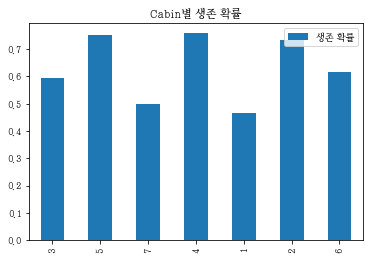

In [130]:
surv_cabin_df.plot.bar()
plt.title('Cabin별 생존 확률')
plt.show()

--------------
Cabin 2,4,5에 묵은 승객들은 생존 확률이 70%대로 매우 높다.
<br><br><br><br><br><br>

In [131]:
#key : Embarked, value : key에 해당하는 전체 승객 id
embarked_dict = defaultdict(list)
#key : Embarked , value: key에 해당하는 생존 승객 id
surv_embarked_dict = defaultdict(list)
#key : Embarked , value: key에 해당하는 승객들의 생존확률
surv_embarked_pct = defaultdict(int)
for i,j in zip(train.Embarked, train.PassengerId) :
    embarked_dict[i].append(j)

for k,v in embarked_dict.items():
    for vv in v:
        if int(train.loc[train.PassengerId == vv].Survived) == 1:
            surv_embarked_dict[k].append(vv)
for pct, k in zip(list(i/j for i,j in zip([len(h) for h in surv_embarked_dict.values()],[len(g) for g in embarked_dict.values()])), surv_embarked_dict.keys()):
    surv_embarked_pct[k] = pct
surv_embarked_pct

defaultdict(int,
            {3: 0.33695652173913043,
             1: 0.5535714285714286,
             2: 0.38961038961038963})

In [132]:
surv_embarked_df = pd.DataFrame.from_dict(surv_embarked_pct, orient= 'index', columns = ['생존 확률'])
surv_embarked_df

,생존 확률
3,0.336957
1,0.553571
2,0.389610


-----------------------------------------
Embarked만 보았을땐 큰 차이가 없어보인다.

Sex + Cabin + Embarked의 조합으로는 어떤 결과가 나올까?
<br><br><br><br><br><br>

In [165]:
cabin_embarked =pd.DataFrame(train.groupby(['Cabin','Embarked'])['Survived'].mean())
cabin_embarked

Survived
Cabin Embarked          
1     1         0.571429
      3         0.375000
2     1         0.772727
      3         0.695652
3     1         0.666667
      2         0.500000
      3         0.555556
4     1         0.846154
      3         0.700000
5     1         1.000000
      2         1.000000
      3         0.692308
6     1         1.000000
      2         0.000000
      3         0.636364
7     3         0.500000
20    3         0.000000

---------------------

In [164]:
female_cabin = pd.DataFrame(train.loc[train.Sex == 1].groupby(['Cabin','Embarked'])['Survived'].mean())
female_cabin

Survived
Cabin Embarked          
1     1         1.000000
2     1         1.000000
      3         1.000000
3     1         0.909091
      2         1.000000
      3         0.866667
4     1         1.000000
      3         1.000000
5     1         1.000000
      2         1.000000
      3         0.900000
6     1         1.000000
      3         1.000000
7     3         0.500000

In [160]:
male_cabin = pd.DataFrame(train.loc[train.Sex == 2].groupby(['Cabin','Embarked'])['Survived'].mean())
male_cabin

Survived
Cabin Embarked          
1     1         0.500000
      3         0.375000
2     1         0.500000
      3         0.300000
3     1         0.400000
      2         0.000000
      3         0.333333
4     1         0.600000
      3         0.400000
5     1         1.000000
      3         0.562500
6     2         0.000000
      3         0.428571
20    3         0.000000

<br><br>
# 예측 모델 생성

## 피처 선택

In [ ]:
#위 분석을 바탕으로 피처 선택
feature1 = ['Age','Sex','Fare','Pclass']
feature2 = ['Cabin','Age','Sex','Fare','Pclass'] 
feature3 = ['Age', 'Sex','Fare','Pclass','Embarked']
feature4 = ['Cabin','Age','Sex','Fare','Pclass','Embarked']
feature5 = ['Age','Sex','Fare','Pclass','Family']
feature6 = ['Cabin','Age','Sex','Fare','Pclass','Family']
feature7 = ['Age','Sex','Fare','Pclass','Family','Embarked']
feature8 = ['Cabin','Age','Sex','Fare','Pclass','Family','Embarked']

결측치 처리 방식에 따라 Train 데이터셋 분류)

x1 = Age결측치 예측값으로 채운 것

x2 = Age, Cabin결측치 예측값(Cabin의 feature 2개)으로 채운 것

x3 = Age결측치 삭제한 것

x4 = Age, Cabin결측치 예측값(Cabin의 feature 3개)으로 채운 것

In [ ]:
#테스트, 트레인 x,y값 return
def xy(feature, num):
    global train_age, train_cabin_2, train_3, train_del_age
    if num == 1:
        return train_test_split(train_age[feature], train_age['Survived'],test_size = 0.25)
    elif num == 2:
        return train_test_split(train_cabin_2[feature], train_cabin_2['Survived'],test_size = 0.25)
    elif num == 3:
        return train_test_split(train_del_age[feature], train_del_age['Survived'],test_size = 0.25)
    elif num == 4:
        return train_test_split(train_cabin_3[feature], train_cabin_3['Survived'],test_size = 0.25)
    return 0
    

In [ ]:
#실제 적용 x,y값
def xy_real(feature, num):
    global train_age, train_cabin_2, train_3, train_del_age, test
    if num == 1:
        return train_age[feature], test_age[feature] , train_age['Survived'] 
    elif num == 2:
        return train_cabin_2[feature],test_cabin_2[feature], train_cabin_2['Survived']
    elif num == 3:
        return train_del_age[feature],test_age[feature], train_del_age['Survived']
    elif num == 4:
        return train_cabin_3[feature],test_cabin_3[feature], train_cabin_3['Survived']    
    return 0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
#model 적용 및 평가
def model_result(feature, x_num, model):
    x_train, x_test, y_train, y_test = xy(feature,x_num)
    model.fit(x_train, y_train)
    print(confusion_matrix(model.predict(x_test), y_test),'\n\n')
    print(classification_report(model.predict(x_test), y_test))
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fp,tp, thres = roc_curve(y_test,y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    print('\nAUC=',auc)
    plt.plot(fp,tp)
    plt.show()

## 모델 구축

- Decision Tree 직접 구축

In [ ]:
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})

    for index, row in df.iterrows():

        #0으로 초기화(죽은사람이 더 많으니까)
        Model.loc[index, 'Predict'] = 0

        #여성이면 일단 생존
        if (df.loc[index, 'Sex'] == 1):
                  Model.loc[index, 'Predict'] = 1

        #Cabin이 2,4,5 중 하나면 생존
        if (df.loc[index, 'Cabin'] in [2,4,5]) :
            Model.loc[index, 'Predict'] = 1
            
        if ((df.loc[index, 'Sex'] == 1) & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 3)  &
            (df.loc[index, 'Fare'] < df.Fare.mean())

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 2) &
            (df.loc[index, 'Pclass'] == 3)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model

- Logistic Regression 적용

In [ ]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()

- Naive Bayes 적용

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()

- SVM 적용

In [ ]:
from sklearn import svm
svm_clf = svm.SVC(probability = True)

- Decision Tree 적용

- Random Forest 적용

In [ ]:
rf_clf = RandomForestClassifier()

- Gradient Boost Regression Tree 적용

In [ ]:
model = [
    
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
]

# 모델 성능 평가

------------------------
## Logistic Regression

x1 적용)

In [ ]:
model_result(feature1,1,log_clf)

In [ ]:
model_result(feature3,1,log_clf)

In [ ]:
model_result(feature5,1,log_clf)

In [ ]:
model_result(feature7,1,log_clf)

x2 적용)

In [ ]:
model_result(feature2,2,log_clf)

In [ ]:
model_result(feature4,2,log_clf)

In [ ]:
model_result(feature6,2,log_clf)

In [ ]:
model_result(feature8,2,log_clf)

x3 적용)

In [ ]:
model_result(feature1,3,log_clf)

In [ ]:
model_result(feature3,3,log_clf)

In [ ]:
model_result(feature5,3,log_clf)

In [ ]:
model_result(feature7,3,log_clf)

x4 적용)

In [ ]:
model_result(feature2,4,log_clf)

In [ ]:
model_result(feature4,4,log_clf)

In [ ]:
model_result(feature6,4,log_clf)

In [ ]:
model_result(feature8,4,log_clf)

-----------------------------
## SVM

x1 적용)

In [ ]:
model_result(feature1,1,svm_clf)

In [ ]:
model_result(feature3,1,svm_clf)

In [ ]:
model_result(feature5,1,svm_clf)

In [ ]:
model_result(feature7,1,svm_clf)

x2 적용)

In [ ]:
model_result(feature2,2,svm_clf)

In [ ]:
model_result(feature4,2,svm_clf)

In [ ]:
model_result(feature6,2,svm_clf)

In [ ]:
model_result(feature8,2,svm_clf)

x3 적용)

In [ ]:
model_result(feature1,3,svm_clf)

In [ ]:
model_result(feature3,3,svm_clf)

In [ ]:
model_result(feature5,3,svm_clf)

In [ ]:
model_result(feature7,3,svm_clf)

x4 적용)

In [ ]:
model_result(feature2,4,svm_clf)

In [ ]:
model_result(feature4,4,svm_clf)

In [ ]:
model_result(feature6,4,svm_clf)

In [ ]:
model_result(feature8,4,svm_clf)

-------------------------
## Naive Bayes

x1 적용)

In [ ]:
model_result(feature1,1,nb_clf)

In [ ]:
model_result(feature3,1,nb_clf)

In [ ]:
model_result(feature5,1,nb_clf)

In [ ]:
model_result(feature7,1,nb_clf)

x2 적용)

In [ ]:
model_result(feature2,2,nb_clf)

In [ ]:
model_result(feature4,2,nb_clf)

In [ ]:
model_result(feature6,2,nb_clf)

In [ ]:
model_result(feature8,2,nb_clf)

x3 적용)

In [ ]:
model_result(feature1,3,nb_clf)

In [ ]:
model_result(feature3,3,nb_clf)

In [ ]:
model_result(feature5,3,nb_clf)

In [ ]:
model_result(feature7,3,nb_clf)

x4 적용)

In [ ]:
model_result(feature2,4,nb_clf)

In [ ]:
model_result(feature4,4,nb_clf)

In [ ]:
model_result(feature6,4,nb_clf)

In [ ]:
model_result(feature8,4,nb_clf)

----------------------------


In [ ]:
#최종 선정 모델, 피처
x_train, x_test,y_train = xy_real(feature, 1)
model.fit(x_train, y_train)
y_test = model.predict(x_test)

In [ ]:
submission = pd.read_csv('Desktop/데이터분석/titanic/gender_submission.csv')
submission['Survived']= y_test

In [ ]:
submission.to_csv('Desktop/데이터분석/Titanic/submission_log_x3_f5.csv',index =  False)